### MIDI file to matrix

Eunjeong Stella Ko (eko@ucsd.edu)

This is how I get a MIDI matrix from a file with 8th note divisions. The resulting matrix is of shape (event, num_notes). After this data processing, I trained and generated new sequence of midi file.

In [134]:
# for piano roll processing
# Unroll:
# Python package for Piano roll transcription to sheet music
# https://github.com/Zulko/unroll
# Music21 Documentation:
# http://web.mit.edu/music21/doc/index.html

In [135]:
# for dataSet
from unroll.KeyStrikes import KeyStrikes
import music21
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [176]:
# for indexing 
# tick_step = mf.ticksPerQuarterNote / 2    
# tick_step (default: 512, changed after reading midi file)
tick_step = 512
samples_num = 0                                # samples number, will initialized
seq_length = 0                                 # sequence length, will initialized
# hidden size
note_dim = 128                            # midi file format : total 128
data_dim = note_dim + 1                   # EOS
hidden_size = data_dim                    # just naming, data dimention == hidden size

In [190]:
target_str = ""                     
#TARGET_FOLDER = "test"               # training folder name (right now, I just put 1 midi file for testing)
TARGET_FOLDER = "waltzes"
path_train = "./train_data/" + TARGET_FOLDER

In [191]:
# target_str
samples_list = os.listdir(path_train) 
        
if target_str != "":
    temp_list_train_files = []
    for item in samples_list:
            if target_str in item:
                temp_list_train_files.append(item)
                samples_list = temp_list_train_files

# sample list sorting
samples_list.sort()
# sample number
samples_num = len(samples_list)

print "{0} file name list.".format(len(samples_list))
print len(samples_list), samples_list

5 file name list.
5 ['waltzes_simple_chords_1.mid', 'waltzes_simple_chords_2.mid', 'waltzes_simple_chords_3.mid', 'waltzes_simple_chords_6.mid', 'waltzes_simple_chords_7.mid']


In [192]:
# return: seq_length 
# for setting up numpy array size, checking the maximum length in training data

#whatislongestfile = ""
#print "\n...... get info : longest sequence length ......"
max_ks_time = 0
mfticksperquarternote = 0

for filename in samples_list:
    print filename

waltzes_simple_chords_1.mid
waltzes_simple_chords_2.mid
waltzes_simple_chords_3.mid
waltzes_simple_chords_6.mid
waltzes_simple_chords_7.mid


In [193]:
# read midi file
mf = music21.midi.MidiFile()
path_midifile = path_train + '/' + filename
mf.open(path_midifile)
mf.read()
mf.close()

# midi -> music21 stream -> midi
# mf.ticksperQuarterNote == 1024
s = music21.midi.translate.midiFileToStream(mf)
mf = music21.midi.translate.streamToMidiFile(s)

# note information
#
#   <MidiTrack 1 -- 1092 events
#   <MidiEvent DeltaTime, t=0, track=1, channel=1>
#   .....
#   <MidiEvent TIME_SIGNATURE, t=0, track=1, channel=1, data='\x04\x02\x18\x08'>
#   <MidiEvent DeltaTime, t=0, track=1, channel=1>
#   <MidiEvent NOTE_ON, t=0, track=1, channel=1, pitch=76, velocity=105>
#   <MidiEvent DeltaTime, t=512, track=1, channel=1>
#   <MidiEvent NOTE_OFF, t=0, track=1, channel=1, pitch=76, velocity=0>
#
result = []
for i in range(len(mf.tracks)):
    t = 0
    for e in mf.tracks[i].events:
        if e.isDeltaTime() and e.time is not None:
            t += e.time
        elif e.isNoteOn() and e.pitch is not None and e.velocity != 0:
            result.append({'time': t, 'note': e.pitch})

# unroll.KeyStrikes
ks = KeyStrikes(result)
# checking duration
ks = ks.quantized(mf.ticksPerQuarterNote)
mfticksperquarternote = mf.ticksPerQuarterNote

# checking maximum length for setting seq_length
now_ks_time = ks.keystrikes[-1]['time'] + ks.keystrikes[-1]['duration'] * mfticksperquarternote
if max_ks_time < now_ks_time:
    max_ks_time = now_ks_time
    whatislongestfile = filename
        
tick_step = mf.ticksPerQuarterNote / 2              # 1/8
longest_seq_length = max_ks_time / tick_step + 1    # EOS

seq_length = longest_seq_length

print "\n\tLongest File : {0}, sequence length : {1}\n\n".format(whatislongestfile, longest_seq_length)
print longest_seq_length



	Longest File : waltzes_simple_chords_7.mid, sequence length : 391


391


In [194]:
print samples_num
print samples_list
print seq_length

# data_set initialization
X_train = np.zeros((samples_num, seq_length, hidden_size), dtype=int)
Y_train = np.copy(X_train)


5
['waltzes_simple_chords_1.mid', 'waltzes_simple_chords_2.mid', 'waltzes_simple_chords_3.mid', 'waltzes_simple_chords_6.mid', 'waltzes_simple_chords_7.mid']
391


	Midi file(=./train_data/waltzes/waltzes_simple_chords_1.mid) loaded. Total 1/8 beats = 390
	Midi file(=./train_data/waltzes/waltzes_simple_chords_2.mid) loaded. Total 1/8 beats = 198
	Midi file(=./train_data/waltzes/waltzes_simple_chords_3.mid) loaded. Total 1/8 beats = 198
	Midi file(=./train_data/waltzes/waltzes_simple_chords_6.mid) loaded. Total 1/8 beats = 294
	Midi file(=./train_data/waltzes/waltzes_simple_chords_7.mid) loaded. Total 1/8 beats = 390


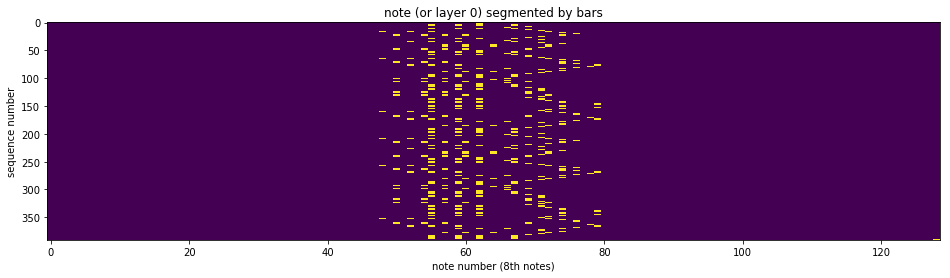

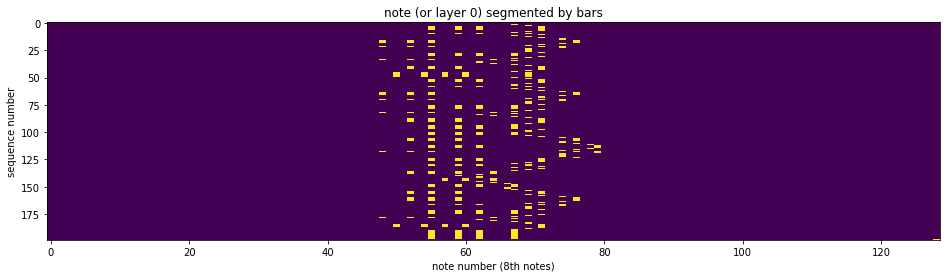

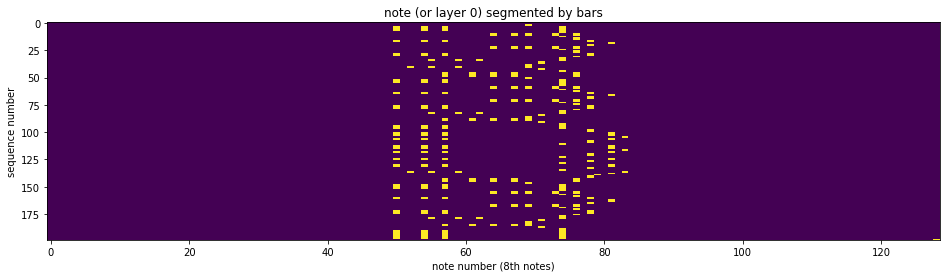

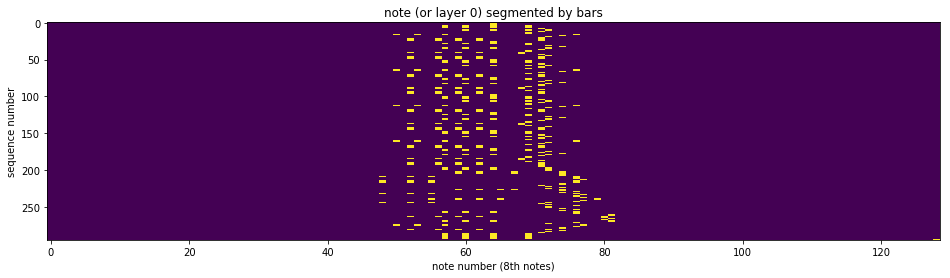

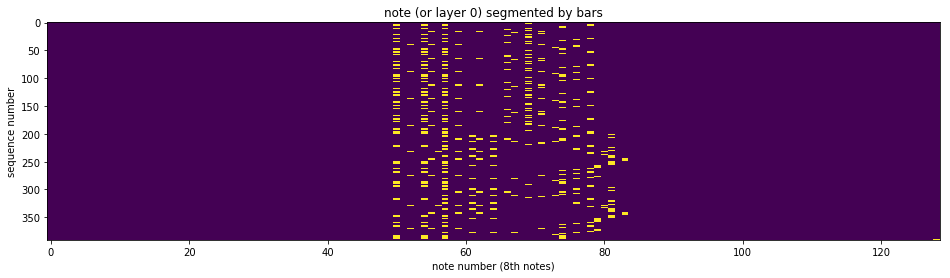

In [195]:
# convert from midi to vector

get_longest_length=True
samples_cnt = 0         

for filename in samples_list:
            
    # read midi file
    mf = music21.midi.MidiFile()
    path_midifile = path_train + '/' + filename
    mf.open(path_midifile)
    mf.read()
    mf.close()

    # midi -> music21 stream -> midi
    s = music21.midi.translate.midiFileToStream(mf)
    mf = music21.midi.translate.streamToMidiFile(s)
    
    result = []
    for i in range(len(mf.tracks)):
        t = 0
        for e in mf.tracks[i].events:
            if e.isDeltaTime() and e.time is not None:
                t += e.time
            elif e.isNoteOn() and e.pitch is not None and e.velocity != 0:
                result.append({'time': t, 'note': e.pitch})

    ks = KeyStrikes(result)
    ks = ks.quantized(mf.ticksPerQuarterNote)

    # tick = 1/8
    tick_step = mf.ticksPerQuarterNote / 2
    total_tick = ks.keystrikes[-1]['time'] + ks.keystrikes[-1]['duration'] * mf.ticksPerQuarterNote
    # total sequence
    total_beat = total_tick / tick_step
    
    # from midi to vector initialization
    one_X_train = np.zeros((total_beat + 1, data_dim), dtype='int32')

    # 1024
    for strike in ks.keystrikes:
        # 1/8 note
        idx = strike['time'] / tick_step
        # 1/8 note duration
        dur = int(strike['duration'] * 2)

        for note in strike['note']:
            for i in range(dur):
                one_X_train[idx + i, note] = 1

    # if data_dim[-1] = 1, EOS
    one_X_train[-1, note_dim] = 1

    print '\tMidi file(=%s) loaded. Total 1/8 beats = %d' % (path_midifile, total_beat)
    #print one_X_train    
    
    # plot the bar-length sequences
    plt.figure(figsize=(16,4))
    plt.imshow(one_X_train, aspect='auto', interpolation='nearest')
    plt.xlabel('note number (8th notes)')
    plt.ylabel('sequence number')
    plt.title('note (or layer 0) segmented by bars')\


    X_train[samples_cnt][seq_length - one_X_train.shape[0] + 1:][:] = np.copy(one_X_train[:-1][:])    
    samples_cnt += 1


# Y_train setting
Y_train[:][:-1][:] = np.copy(X_train[:][1:][:])


In [196]:
# for debug
#print "\n\tX_train.shape : {0},        Y_train.shape : {1}".format(X_train.shape, Y_train.shape)
#print "\tX_train : ", X_train
#print "\tY_train : ", Y_train
#print "\tsamples_num : ", samples_num
#print "\tseq_length : ", seq_length
#print "\tdata_dim : ", data_dim

#return X_train, Y_train, self.samples_num, self.seq_length, self.data_dim